In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import gzip
import glob
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [3]:
!pip install scprep

     |████████████████████████████████| 104 kB 5.2 MB/s 


In [4]:
import scprep as scp
# The scprep require data of format (# of samples, # of features)

In [5]:
ped_expression_1000 = pd.read_csv("/content/drive/MyDrive/ML4fungen/Final project/ped_expression_1000_test.csv", index_col=0, header=None, )
adult_expression_1000 = pd.read_csv("/content/drive/MyDrive/ML4fungen/Final project/adult_expression_1000_test.csv", index_col=0, header=None, )


In [6]:
genes_list = ped_expression_1000.index

In [7]:
print(ped_expression_1000.astype(bool).sum(axis=1))

0
MAGEA3        86
MAGEA12       78
IGF2-AS      218
HENMT1       256
MAGEA2B       43
            ... 
COL6A6        29
PCDHGA3      131
LOC730811     29
CLVS1        162
GPC5          42
Length: 1000, dtype: int64


In [ ]:
adult_expression_1000.astype(bool).sum(axis=1)

0
MAGEA3         3
MAGEA12        3
IGF2-AS        4
HENMT1        10
MAGEA2B        2
            ... 
COL6A6       140
PCDHGA3      827
LOC730811    133
CLVS1        811
GPC5         199
Length: 1000, dtype: int64

In [ ]:
ped_expression_1000

,1,2,3,4,5,6,7,8,9,10,...,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947
0,,,,,,,,,,,,,,,,,,,,,
MAGEA3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
MAGEA12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
IGF2-AS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
HENMT1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
MAGEA2B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COL6A6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
PCDHGA3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.06527,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
LOC730811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


# Perform data filtering

### Filter all genes with zero counts across all cells.


In [9]:
# Looks like none of the genes are filtered out! 
ped_expression_1000 = scp.filter.filter_empty_genes(ped_expression_1000.T)
adult_expression_1000 = scp.filter.filter_empty_genes(adult_expression_1000.T)

# this filtering technique is equivalent to: 
# ped_expression_200.loc[:, (ped_expression_200 != 0).any(axis=0)]

### Remove all cells with zero library size.

In [10]:
# Looks like we filtered out several "empty" cells
ped_expression_1000_filtered = scp.filter.filter_empty_cells(ped_expression_1000)
adult_expression_1000_filtered = scp.filter.filter_empty_cells(adult_expression_1000)

### IMPORTANT: Other filtering method that I could try (things to try in the future): 
1. Remove cells with total expression of a gene set above or below a threshold.

2. Filter all genes with negligible counts in all but a few cells (rare genes)

But for now, I'll do the basics -- just filter out genes with zero counts and zero library size. 

# Merge the pediatric dataset with the adult dataset

In [11]:
print("shape of the ped dataset: ", ped_expression_1000_filtered.shape)
print("shape of the adult dataset: ", adult_expression_1000_filtered.shape)

shape of the ped dataset:  (1947, 1000)
shape of the adult dataset:  (4916, 1000)


In [12]:
(ped_expression_1000_filtered.shape[0])

1947

### IMPORTANT: Assign class name to pediatric and adult malignant cells

0: pediatric GBM 

1: adult GBM

In [13]:
class_ped = np.zeros(ped_expression_1000_filtered.shape[0], dtype=int)
ped_expression_1000_filtered['class'] = class_ped

class_adult = np.ones(adult_expression_1000_filtered.shape[0], dtype=int)
adult_expression_1000_filtered['class'] = class_adult

### merge the two datasets into a combined dataset

In [14]:
frames = [ped_expression_1000_filtered, adult_expression_1000_filtered]

expression_combined = pd.concat(frames)

### Fix the index of the combined dataset, because we have filtered out some data, now the indices are messed up

In [15]:
expression_combined.index = range(len(expression_combined))

In [16]:
expression_combined

,MAGEA3,MAGEA12,IGF2-AS,HENMT1,MAGEA2B,MAGEA2,DIO3,KHDRBS2,CLEC10A,NPBWR2,...,PLD5,EVA1C,LOC100506497,LOC100873065,COL6A6,PCDHGA3,LOC730811,CLVS1,GPC5,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.00000,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.00000,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.00000,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.00000,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.03101,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,2.23836,0.0,0.0,0.0,0.816730,0.0,3.34338,0.00000,1
6859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,1.29283,0.0,0.0,0.0,0.000000,0.0,0.00000,0.00000,1
6860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,2.540050,0.0,0.00000,1.87897,1
6861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.387715,0.0,0.00000,0.00000,1


### create the label dataset

In [17]:
y = expression_combined['class']

In [18]:
dataset = expression_combined.drop('class', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


# Train_test_split

In [19]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(y, test_size=0.33, random_state=42, stratify=y)
X_train = dataset.loc[y_train.index]
X_test = dataset.loc[y_test.index]

## Adding validation set
y_train, y_val = train_test_split(y_train, test_size=0.25, random_state=42, stratify=y_train) # 0.25* 0.66 = 0.165 
X_train = dataset.loc[y_train.index]
X_val = dataset.loc[y_val.index]


In [20]:
print("shape of X_train", X_train.shape)
print("shape of y_train", y_train.shape)

print("shape of X_test", X_test.shape)
print("shape of y_test", y_test.shape)

print("shape of X_val", X_val.shape)
print("shape of y_val", y_val.shape)


shape of X_train (3448, 1000)
shape of y_train (3448,)
shape of X_test (2265, 1000)
shape of y_test (2265,)
shape of X_val (1150, 1000)
shape of y_val (1150,)


In [21]:
def reshape_x(data):
  return np.array(data).reshape(data.shape[0], data.shape[1], 1)
  
X_train = reshape_x(X_train)
X_test = reshape_x(X_test)
X_val = reshape_x(X_val)


In [22]:
X_val.shape

(1150, 1000, 1)

In [23]:
# Evaluation function
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2', '3']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

# Autoencoder model 1: Convolutional autoencoder


In [24]:
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv1D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv1DTranspose, MaxPooling1D, UpSampling1D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.utils import plot_model


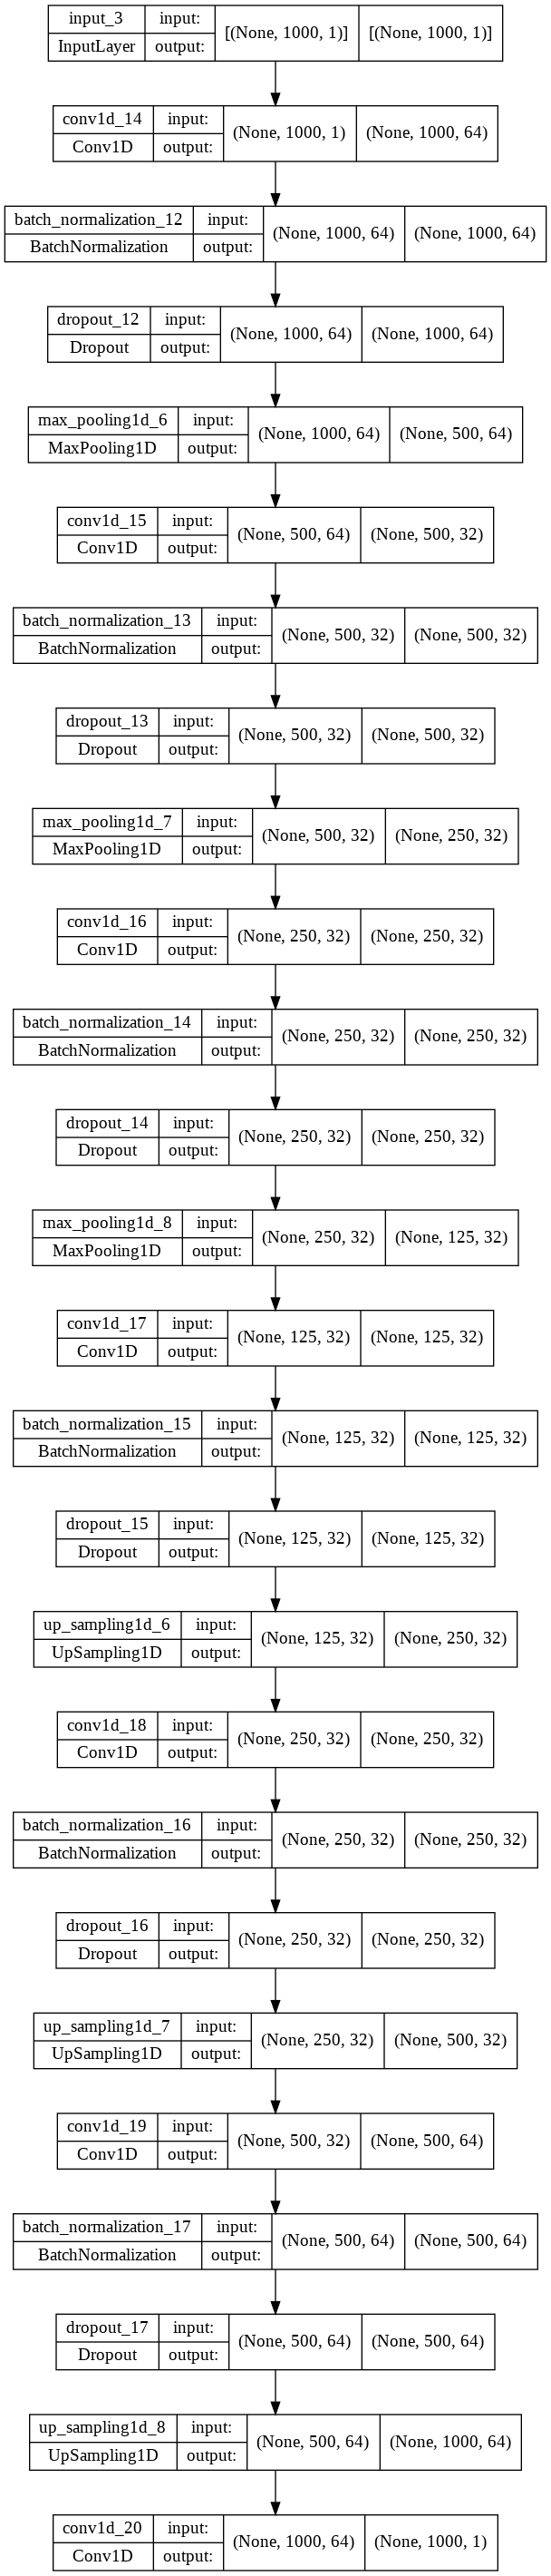

In [28]:
# define encoder
input_window = Input(shape=(1000, 1))
x = Conv1D(64, 3, activation="relu", padding="same")(input_window)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(2, padding="same")(x)
x = Conv1D(32, 3, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(2, padding="same")(x)
x = Conv1D(32, 3, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
encoded = MaxPooling1D(2, padding="same")(x)
encoder = Model(input_window, encoded)

# define decoder
x = Conv1D(32, 3, activation="relu", padding="same")(encoded)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) 
autoencoder = Model(input_window, decoded)
plot_model(autoencoder, show_shapes=True, to_file='CNN_autoencoder.png')


In [27]:
print(autoencoder.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 1)]         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 1000, 64)          256       
                                                                 
 batch_normalization_6 (Batc  (None, 1000, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 1000, 64)          0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 500, 64)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 500, 32)           6176

In [29]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'] )

In [30]:
history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                verbose=2, 
                validation_data=(X_val, X_val))

Epoch 1/50
108/108 - 23s - loss: 0.3922 - accuracy: 0.8121 - val_loss: 0.4037 - val_accuracy: 0.9419 - 23s/epoch - 209ms/step
Epoch 2/50
108/108 - 4s - loss: 0.3254 - accuracy: 0.8810 - val_loss: 0.3707 - val_accuracy: 0.9387 - 4s/epoch - 38ms/step
Epoch 3/50
108/108 - 4s - loss: 0.3031 - accuracy: 0.8970 - val_loss: 0.3117 - val_accuracy: 0.9256 - 4s/epoch - 38ms/step
Epoch 4/50
108/108 - 4s - loss: 0.2941 - accuracy: 0.9015 - val_loss: 0.2843 - val_accuracy: 0.9155 - 4s/epoch - 40ms/step
Epoch 5/50
108/108 - 4s - loss: 0.2891 - accuracy: 0.9033 - val_loss: 0.2794 - val_accuracy: 0.9084 - 4s/epoch - 38ms/step
Epoch 6/50
108/108 - 4s - loss: 0.2863 - accuracy: 0.9041 - val_loss: 0.2751 - val_accuracy: 0.9098 - 4s/epoch - 38ms/step
Epoch 7/50
108/108 - 4s - loss: 0.2839 - accuracy: 0.9047 - val_loss: 0.2736 - val_accuracy: 0.9090 - 4s/epoch - 38ms/step
Epoch 8/50
108/108 - 4s - loss: 0.2824 - accuracy: 0.9052 - val_loss: 0.2730 - val_accuracy: 0.9089 - 4s/epoch - 38ms/step
Epoch 9/50
10

In [31]:
decoded_exp = autoencoder.predict(X_test)

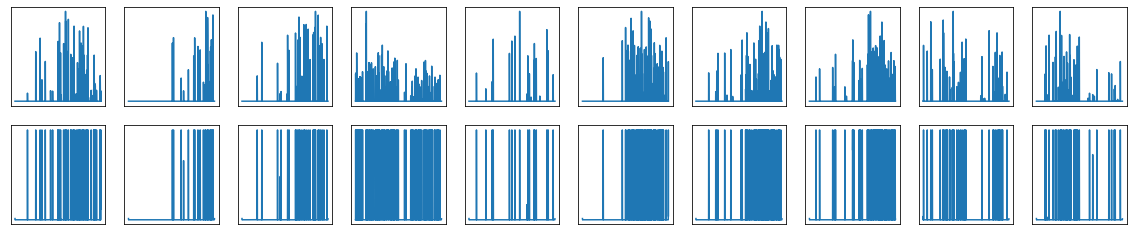

In [32]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.plot(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.plot(decoded_exp[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# encoder = keras.Model(input_img, encoded)
# encoded_imgs = encoder.predict(x_test)


In [ ]:
# difference = []

# zip_object = zip(list1, list2)
# for list1_i, list2_i in zip_object:
#     difference.append(list1_i-list2_i)

# list_with_abs = []
# for item in difference:
#     list_with_abs.append(abs(item))

# print(list_with_abs)

# View the data in PCA plot

In [33]:
decoded_exp_pca = decoded_exp.reshape(-1, 1000)
X_test_pca = X_test.reshape(-1, 1000)

In [34]:
decoded_exp.shape

(2265, 1000, 1)

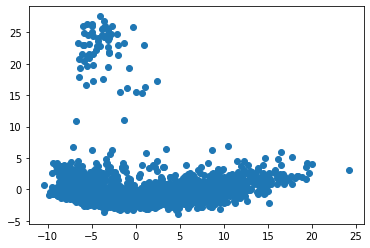

In [35]:
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(X_test_pca)
plot = plt.scatter(Xt[:,0], Xt[:,1])
plt.show()

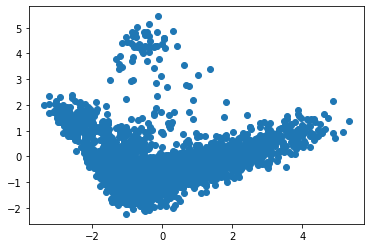

In [36]:
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(decoded_exp_pca)
plot = plt.scatter(Xt[:,0], Xt[:,1])
plt.show()

In [37]:
X_test.shape

(2265, 1000, 1)

In [38]:
decoded_train = autoencoder.predict(X_train)
decoded_test = autoencoder.predict(X_test)
decoded_val = autoencoder.predict(X_val)

# CNN model 1 --> one used in final report

In [39]:
from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Embedding, Input, LSTM, Bidirectional, GlobalAveragePooling1D
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
import keras
from matplotlib.pyplot import figure
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import tensorflow as tf

In [40]:
def network(X_train,y_train):
    im_shape=(decoded_train.shape[1],decoded_train.shape[2])
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    
    # Your code
    conv1=Convolution1D(64, 6, activation='relu', input_shape=im_shape, name='Conv1D_1')(inputs_cnn)
    conv1=BatchNormalization(name='BatchNormalization_1')(conv1)
    pool1=MaxPool1D(pool_size=(2), strides=(4), padding="same", name='MaxPool1D_1')(conv1)
    drop = Dropout(0.2)
    conv2=Convolution1D(128, 12, activation='relu', input_shape=im_shape, name='Conv1D_2')(pool1)
    conv2=BatchNormalization(name='BatchNormalization_2')(conv2)
    pool2=MaxPool1D(pool_size=(2), strides=(4), padding="same", name='MaxPool1D_2')(conv2)
    drop = Dropout(0.5)
    flatten=Flatten()(pool2)
    dense_1 = Dense(64, activation='relu', name='Dense_1')(flatten)
    drop = Dropout(0.5)
    dense_2 = Dense(32, activation='relu', name='Dense_2')(dense_1)
    main_output = Dense(units = 1, activation='sigmoid', name='main_output')(dense_2)

    model = Model(inputs= inputs_cnn, outputs=main_output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics = ['accuracy'])

    return(model)

In [41]:
model_combine_data = network(decoded_train,y_train)
print(model_combine_data.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 1000, 1)]         0         
                                                                 
 Conv1D_1 (Conv1D)           (None, 995, 64)           448       
                                                                 
 BatchNormalization_1 (Batch  (None, 995, 64)          256       
 Normalization)                                                  
                                                                 
 MaxPool1D_1 (MaxPooling1D)  (None, 249, 64)           0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 238, 128)          98432     
                                                                 
 BatchNormalization_2 (Batch  (None, 238, 128)         512       
 Normalization)                                            

In [42]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [43]:
# Train you model
history = model_combine_data.fit(decoded_train, y_train,epochs=100, batch_size=32,validation_data=(decoded_val,y_val), callbacks = [es])

Epoch 1/100
108/108 [==============================] - 7s 34ms/step - loss: 0.0580 - accuracy: 0.9771 - val_loss: 0.3450 - val_accuracy: 0.9243
Epoch 2/100
108/108 [==============================] - 3s 28ms/step - loss: 0.0127 - accuracy: 0.9959 - val_loss: 0.1753 - val_accuracy: 0.9678
Epoch 3/100
108/108 [==============================] - 3s 26ms/step - loss: 0.0060 - accuracy: 0.9974 - val_loss: 0.1830 - val_accuracy: 0.9426
Epoch 4/100
108/108 [==============================] - 3s 28ms/step - loss: 9.9137e-04 - accuracy: 0.9997 - val_loss: 0.0533 - val_accuracy: 0.9817
Epoch 5/100
108/108 [==============================] - 3s 29ms/step - loss: 1.0800e-04 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 0.9939
Epoch 6/100
108/108 [==============================] - 3s 25ms/step - loss: 4.1788e-05 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9939
Epoch 7/100
108/108 [==============================] - 2s 22ms/step - loss: 3.0908e-05 - accuracy: 1.0000 - val_loss: 0.0142

Accuracy: 98.94%


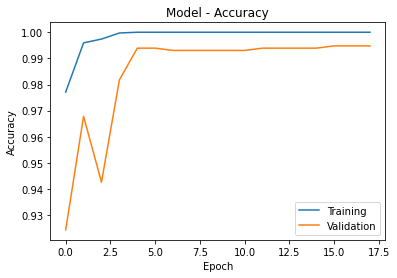

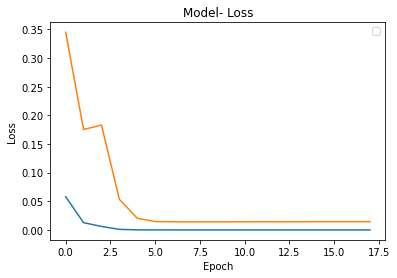

In [44]:
# Print result and plot accuracy and loss
evaluate_model(history,decoded_test,y_test,model_combine_data)
y_pred = model_combine_data.predict(decoded_test)

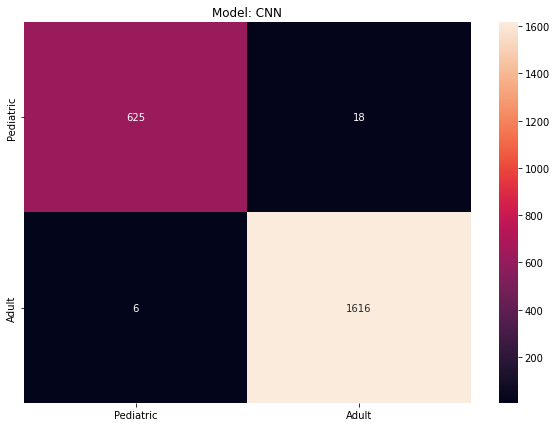

In [45]:
prediction_cnn = model_combine_data.predict(decoded_test)
prediction_cnn = np.round(prediction_cnn)
cfn_matrix_cnn = confusion_matrix(y_test, prediction_cnn)
plt.figure(figsize = (10,7))
plt.title('Model: CNN')
xticklabels = ['Pediatric', 'Adult'] 
yticklabels = ['Pediatric', 'Adult'] 
sns.heatmap(cfn_matrix_cnn, annot = True, fmt = 'd', xticklabels = xticklabels, yticklabels=yticklabels)

In [46]:
from sklearn.metrics import classification_report

target_names = ['Pediatric', 'Adult']

print(classification_report(y_test, prediction_cnn, target_names= target_names))



              precision    recall  f1-score   support

   Pediatric       0.99      0.97      0.98       643
       Adult       0.99      1.00      0.99      1622

    accuracy                           0.99      2265
   macro avg       0.99      0.98      0.99      2265
weighted avg       0.99      0.99      0.99      2265



In [ ]:
model_combine_data

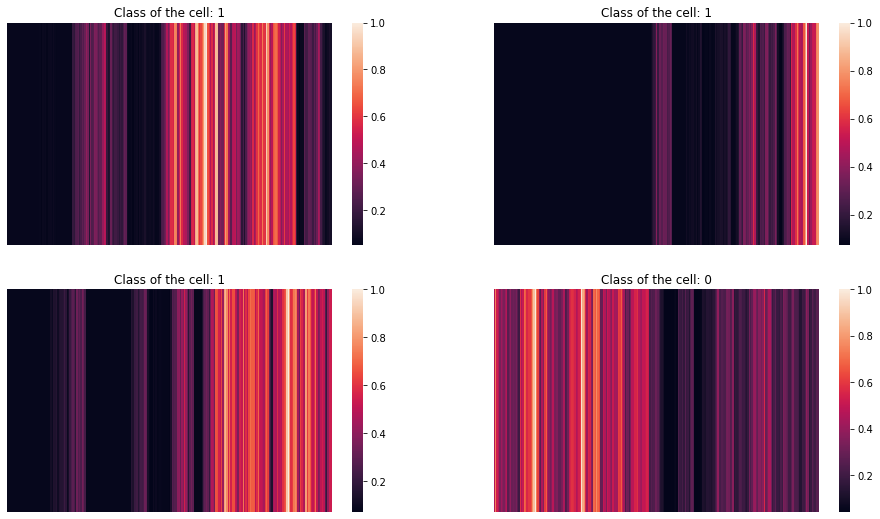

In [ ]:
import numpy as np
import tensorflow as tf


from keras import backend as K
# grads = K.gradients(golden, last_conv_layer.output)[0]

n = 5
plt.figure(figsize=(16, 9))
for i in range(1, n):
  
  heatmap_model = tf.keras.models.Model(
      [model_combine_data.inputs], [model_combine_data.get_layer('Conv1D_2').output, model_combine_data.output]
  )

  with tf.GradientTape() as tape:
      conv_output, predictions = heatmap_model(X_test[i].reshape(-1, 1000))
      loss = predictions[:, np.argmax(predictions[0])]

  grads = tape.gradient(loss, conv_output)
  # print("The class is: ", y_test[y_test.index[0]])
  heatmap = np.mean(conv_output, axis=-1)
  import matplotlib.pyplot as plt
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  # plt.subplot(2,2,i)
  ax = plt.subplot(2, 2, i)
  ax.set_title('Class of the cell: '+ str(y_test[y_test.index[i]]))
  # fig, ax = plt.subplots(figsize=(16, 9))
  sns.heatmap(heatmap, xticklabels = False, yticklabels=False)
  # plt.show()
  # plt.matshow(heatmap)

# CNN model 2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 1000, 128)         1152      
                                                                 
 batch_normalization_18 (Bat  (None, 1000, 128)        512       
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 1000, 128)         0         
                                                                 
 conv1d_22 (Conv1D)          (None, 1000, 128)         131200    
                                                                 
 batch_normalization_19 (Bat  (None, 1000, 128)        512       
 chNormalization)                                                
                                                                 
 dropout_22 (Dropout)        (None, 1000, 128)         0

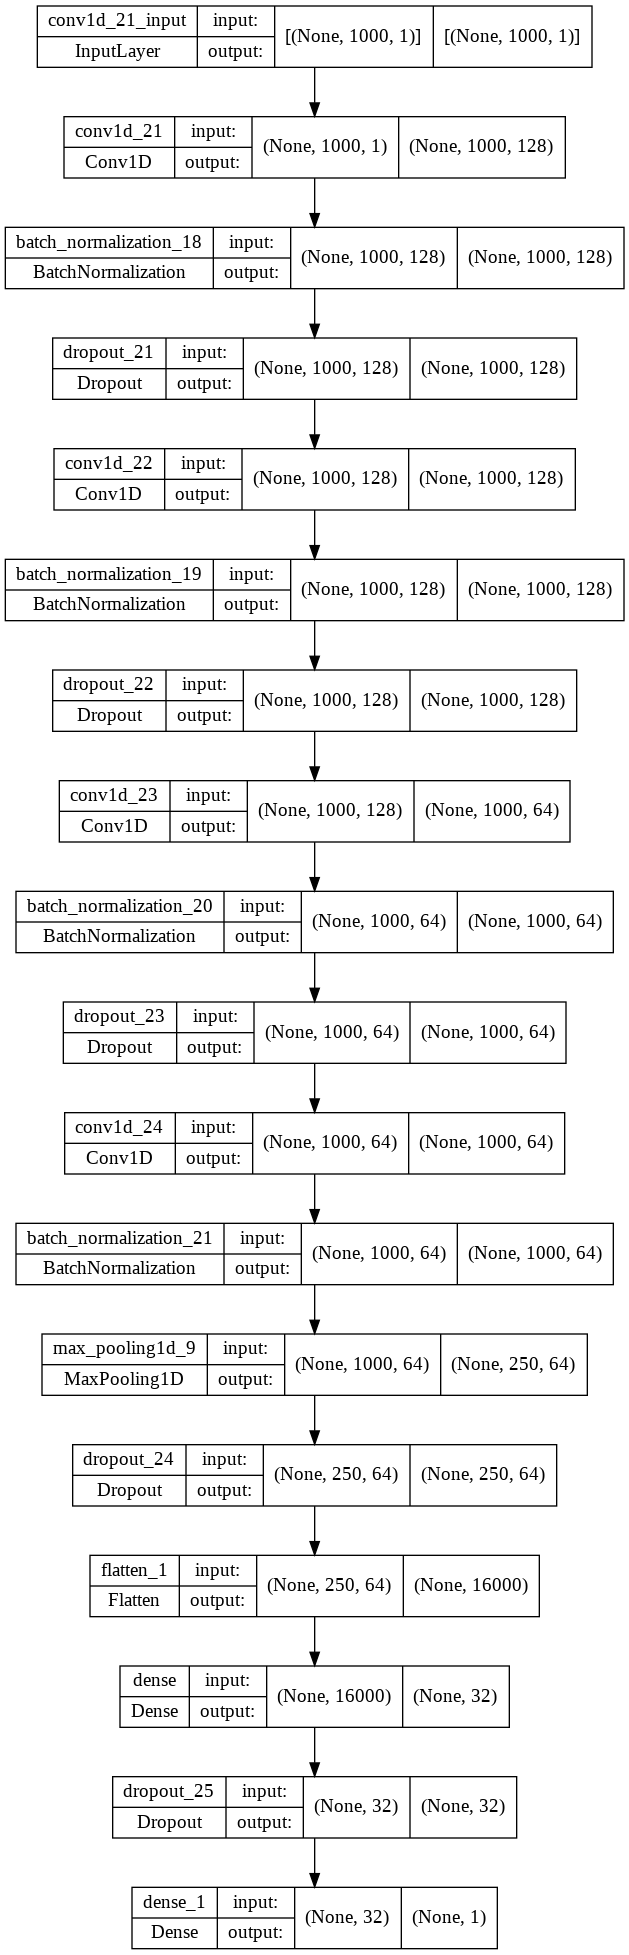

In [47]:
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Dropout, MaxPool1D, Flatten

model_combine_data_new = Sequential()

model_combine_data_new.add(Conv1D(filters=128, kernel_size = 8, padding='same', kernel_initializer='normal', activation='relu', input_shape=(decoded_train.shape[1],decoded_train.shape[2])))
model_combine_data_new.add(BatchNormalization())
model_combine_data_new.add(Dropout(0.2))
model_combine_data_new.add(Conv1D(filters=128, kernel_size= 8, padding='same', kernel_initializer='normal', activation='relu'))
model_combine_data_new.add(BatchNormalization())
model_combine_data_new.add(Dropout(0.2)) 
model_combine_data_new.add(Conv1D(filters=64, kernel_size= 8, padding='same', kernel_initializer='normal', activation='relu'))
model_combine_data_new.add(BatchNormalization())
model_combine_data_new.add(Dropout(0.2))
model_combine_data_new.add(Conv1D(filters=64, kernel_size= 8, padding='same', kernel_initializer='normal', activation='relu'))
model_combine_data_new.add(BatchNormalization())
model_combine_data_new.add(MaxPool1D(pool_size=4)) 
model_combine_data_new.add(Dropout(0.2))

model_combine_data_new.add(Flatten())
model_combine_data_new.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
model_combine_data_new.add(Dropout(0.2))
model_combine_data_new.add(Dense(units=1, activation='sigmoid'))


model_combine_data_new.summary()
plot_model(model_combine_data_new, show_shapes=True, to_file='1.png')


In [48]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_combine_data_new.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_combine_data_new.fit(decoded_train, y_train, epochs=50, batch_size=32, validation_data=(decoded_val,y_val), callbacks = [es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 15s 109ms/step - loss: 0.2916 - accuracy: 0.9588 - val_loss: 0.3214 - val_accuracy: 0.8278
Epoch 2/50
108/108 [==============================] - 11s 102ms/step - loss: 0.0389 - accuracy: 0.9869 - val_loss: 0.2937 - val_accuracy: 0.8470
Epoch 3/50
108/108 [==============================] - 11s 102ms/step - loss: 0.0255 - accuracy: 0.9898 - val_loss: 0.7498 - val_accuracy: 0.7983
Epoch 4/50
108/108 [==============================] - 11s 102ms/step - loss: 0.0234 - accuracy: 0.9936 - val_loss: 0.4924 - val_accuracy: 0.8861
Epoch 5/50
108/108 [==============================] - 11s 102ms/step - loss: 0.0265 - accuracy: 0.9922 - val_loss: 0.0357 - val_accuracy: 0.9870
Epoch 6/50
108/108 [==============================] - 11s 101ms/step - loss: 0.0183 - accuracy: 0.9936 - val_loss: 0.0353 - val_accuracy: 0.9887
Epoch 7/50
108/108 [==============================] - 11s 102ms/step - loss: 0.0125 - accuracy: 0.9959 - val_loss: 0.0429 - val_accuracy: 0.9

Accuracy: 98.90%


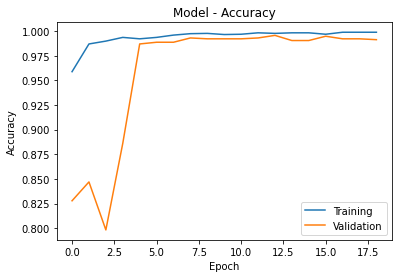

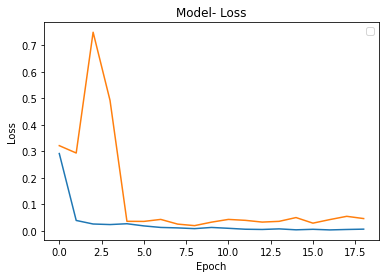

In [49]:
# Print result and plot accuracy and loss
evaluate_model(history,decoded_test,y_test,model_combine_data_new)
y_pred = model_combine_data_new.predict(decoded_test)

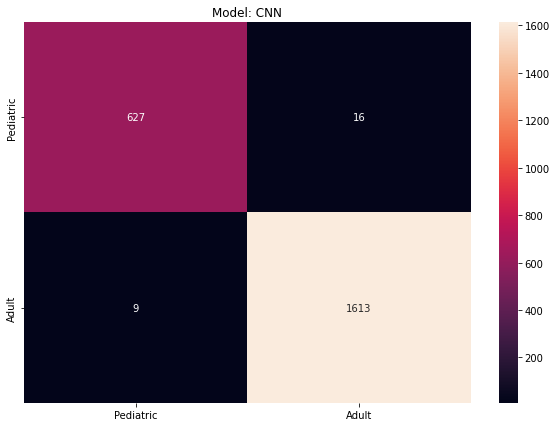

In [50]:
prediction_cnn = model_combine_data_new.predict(decoded_test)
prediction_cnn = np.round(prediction_cnn)
cfn_matrix_cnn = confusion_matrix(y_test, prediction_cnn)
plt.figure(figsize = (10,7))
plt.title('Model: CNN')
xticklabels = ['Pediatric', 'Adult'] 
yticklabels = ['Pediatric', 'Adult'] 
sns.heatmap(cfn_matrix_cnn, annot = True, fmt = 'd', xticklabels = xticklabels, yticklabels=yticklabels)

# MLP 

In [67]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [68]:
decoded_train.shape

(3448, 1000, 1)

In [71]:
from keras.layers import Dropout
# create model
model2 = Sequential()
model2.add(Dense(64, input_dim=1000, activation='relu'))
# model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [72]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [73]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history_mlp = model2.fit(decoded_train, y_train, epochs=50, batch_size=5, validation_data=(decoded_val,y_val), callbacks = [es])


Epoch 1/50
690/690 [==============================] - 4s 6ms/step - loss: 0.0831 - accuracy: 0.9655 - val_loss: 0.0314 - val_accuracy: 0.9887
Epoch 2/50
690/690 [==============================] - 3s 5ms/step - loss: 0.0058 - accuracy: 0.9977 - val_loss: 0.0149 - val_accuracy: 0.9948
Epoch 3/50
690/690 [==============================] - 4s 5ms/step - loss: 7.1505e-04 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 0.9939
Epoch 4/50
690/690 [==============================] - 3s 5ms/step - loss: 1.7454e-04 - accuracy: 1.0000 - val_loss: 0.0175 - val_accuracy: 0.9957
Epoch 5/50
690/690 [==============================] - 3s 5ms/step - loss: 8.8415e-05 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9948
Epoch 6/50
690/690 [==============================] - 3s 5ms/step - loss: 4.9005e-05 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9948
Epoch 7/50
690/690 [==============================] - 3s 5ms/step - loss: 2.8901e-05 - accuracy: 1.0000 - val_loss: 0.0180 - val_acc

Accuracy: 99.03%


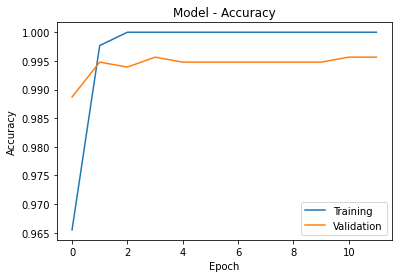

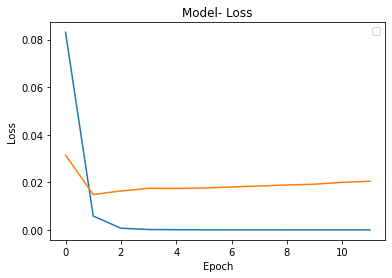

In [74]:
evaluate_model(history_mlp,decoded_test,y_test,model2)
y_pred = model2.predict(decoded_test)

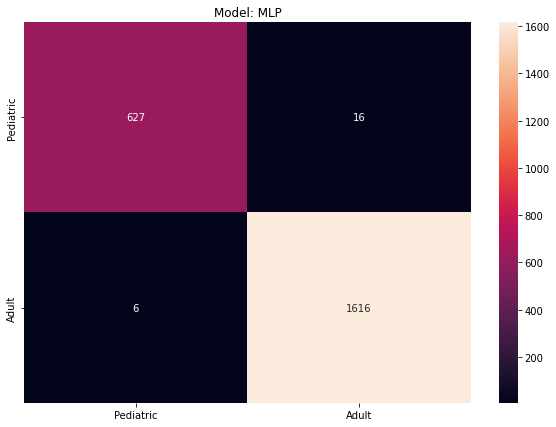

In [76]:
prediction_mlp = model2.predict(decoded_test)

prediction_mlp = np.round(prediction_mlp)
cfn_matrix_mlp = confusion_matrix(y_test, prediction_mlp)
plt.figure(figsize = (10,7))
plt.title('Model: MLP')

xticklabels = ['Pediatric', 'Adult'] 
yticklabels = ['Pediatric', 'Adult'] 
sns.heatmap(cfn_matrix_mlp, annot = True, fmt= 'd', xticklabels = xticklabels, yticklabels=yticklabels)

# LSTM version 2

In [85]:
def network_CNN_LSTM(X_train,y_train):
    im_shape=(decoded_train.shape[1],1)
    inputs_cnn_lstm=Input(shape=(im_shape), name='inputs_cnn_lstm')
    
    lstm = (layers.Bidirectional(layers.LSTM(30, return_sequences=True))(inputs_cnn_lstm))
    lstm = layers.Bidirectional(layers.LSTM(30, return_sequences=True))(lstm)

    # lstm = (LSTM(units=128, name='lstm'))(pool2)
    flatten=Flatten()(lstm)
    dense_end1 = Dense(128, activation='relu')(flatten)
    drop = Dropout(0.2)(dense_end1)
    conv2_1=BatchNormalization()(drop)
    dense_end2 = Dense(64, activation='relu')(conv2_1)
    drop = Dropout(0.2)(dense_end2)
    conv2_1=BatchNormalization()(drop)
    dense_end3 = Dense(32, activation='relu')(conv2_1)
    main_output = Dense(1, activation='sigmoid', name='main_output')(dense_end3)

    
    model = Model(inputs=inputs_cnn_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])
    
    return(model)

In [86]:
model=network_CNN_LSTM(decoded_train,y_train)
print(model.summary())

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn_lstm (InputLayer  [(None, 1000, 1)]        0         
 )                                                               
                                                                 
 bidirectional_8 (Bidirectio  (None, 1000, 60)         7680      
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 1000, 60)         21840     
 nal)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 60000)             0         
                                                                 
 dense_19 (Dense)            (None, 128)               7680128   
                                                          

In [87]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(decoded_train, y_train, epochs=50, batch_size = 32,validation_data=(decoded_val, y_val), callbacks = [es])

Epoch 1/50
108/108 [==============================] - 78s 630ms/step - loss: 0.1491 - accuracy: 0.9521 - val_loss: 0.0478 - val_accuracy: 0.9826
Epoch 2/50
108/108 [==============================] - 66s 616ms/step - loss: 0.0885 - accuracy: 0.9707 - val_loss: 0.0888 - val_accuracy: 0.9774
Epoch 3/50
108/108 [==============================] - 66s 615ms/step - loss: 0.0783 - accuracy: 0.9730 - val_loss: 0.0548 - val_accuracy: 0.9809
Epoch 4/50
108/108 [==============================] - 67s 618ms/step - loss: 0.0626 - accuracy: 0.9771 - val_loss: 0.0285 - val_accuracy: 0.9887
Epoch 5/50
108/108 [==============================] - 67s 618ms/step - loss: 0.0480 - accuracy: 0.9843 - val_loss: 0.0265 - val_accuracy: 0.9896
Epoch 6/50
108/108 [==============================] - 66s 616ms/step - loss: 0.0381 - accuracy: 0.9884 - val_loss: 0.0283 - val_accuracy: 0.9887
Epoch 7/50
108/108 [==============================] - 67s 618ms/step - loss: 0.0373 - accuracy: 0.9864 - val_loss: 0.0419 - val_ac

Accuracy: 98.85%


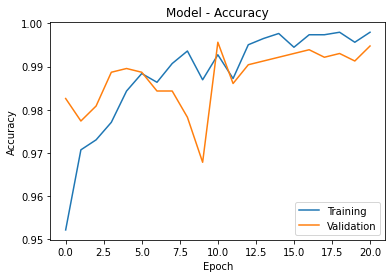

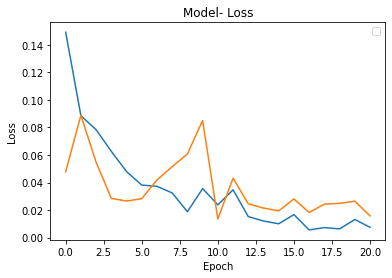

In [88]:
evaluate_model(history, decoded_test,y_test,model )
y_pred = model.predict(decoded_test)


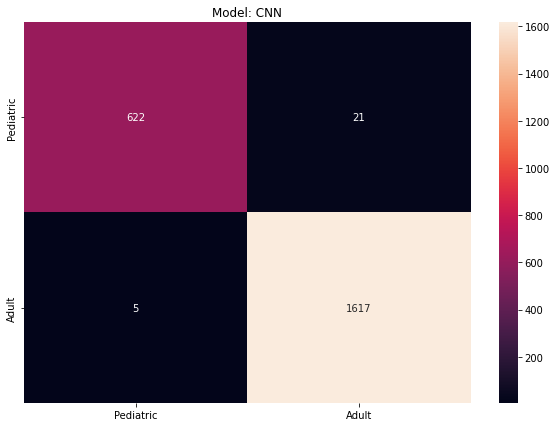

In [89]:
prediction_cnn_lstm = model.predict(decoded_test)
prediction_cnn_lstm = np.round(prediction_cnn_lstm)
cfn_matrix_cnn_lstm = confusion_matrix(y_test, prediction_cnn_lstm)
plt.figure(figsize = (10,7))
plt.title('Model: CNN')
xticklabels = ['Pediatric', 'Adult'] 
yticklabels = ['Pediatric', 'Adult'] 
sns.heatmap(cfn_matrix_cnn_lstm, annot = True, fmt = 'd', xticklabels = xticklabels, yticklabels=yticklabels)

In [90]:
from sklearn.metrics import classification_report

target_names = ['Pediatric', 'Adult']

print(classification_report(y_test, prediction_cnn_lstm, target_names= target_names))



              precision    recall  f1-score   support

   Pediatric       0.99      0.97      0.98       643
       Adult       0.99      1.00      0.99      1622

    accuracy                           0.99      2265
   macro avg       0.99      0.98      0.99      2265
weighted avg       0.99      0.99      0.99      2265



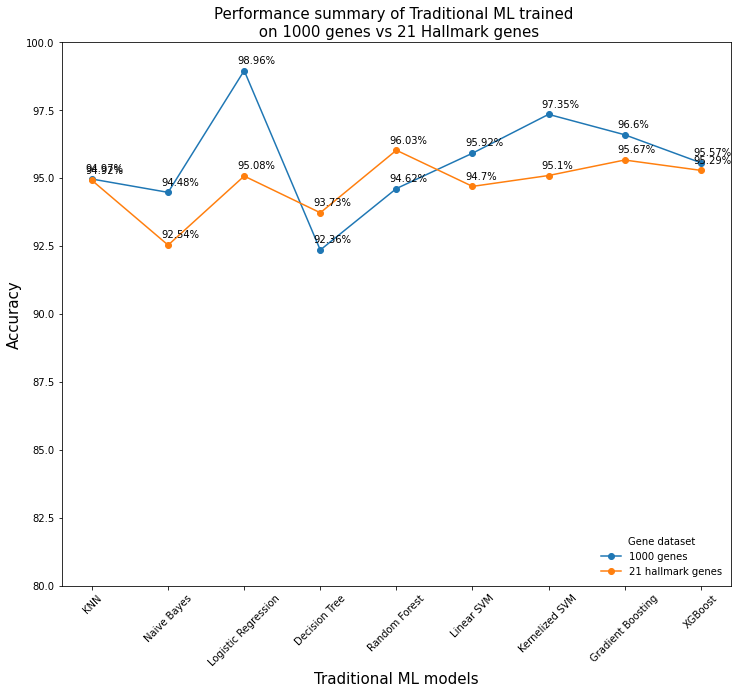

In [5]:
import matplotlib.pyplot as plt

result_2000genes = [94.97, 94.48, 98.96, 
                    92.36, 94.62, 95.92, 
                    97.35, 96.60, 95.57]


result_21genes = [94.92, 92.54, 95.08,
                  93.73, 96.03, 94.70,
                  95.10, 95.67, 95.29]

methods = ['KNN', 'Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Linear SVM', 'Kernelized SVM', 'Gradient Boosting', 'XGBoost']
# Initialise the figure and axes.
fig, ax = plt.subplots(1, figsize=(12, 10))
# Set the title for the figure
plt.title('Performance summary of Traditional ML trained \n on 1000 genes vs 21 Hallmark genes', fontsize=15, )

plt.plot(methods, result_2000genes, 'o-', label="1000 genes")
plt.plot(methods, result_21genes, 'o-', label="21 hallmark genes")     

plt.legend(loc="lower right", title="Gene dataset", frameon=False)

plt.xticks(rotation = 45)
plt.xlabel('Traditional ML models', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

for i, v in enumerate(result_21genes):
    ax.annotate(str(v)+"%", xy=(i,v), xytext=(-7,7), textcoords='offset points')

for i, v in enumerate(result_2000genes):
    ax.annotate(str(v)+"%", xy=(i,v), xytext=(-7,7), textcoords='offset points')

ax.set_ylim([80, 100])

plt.savefig("High resoltion_traditionalML.png",dpi=1000)


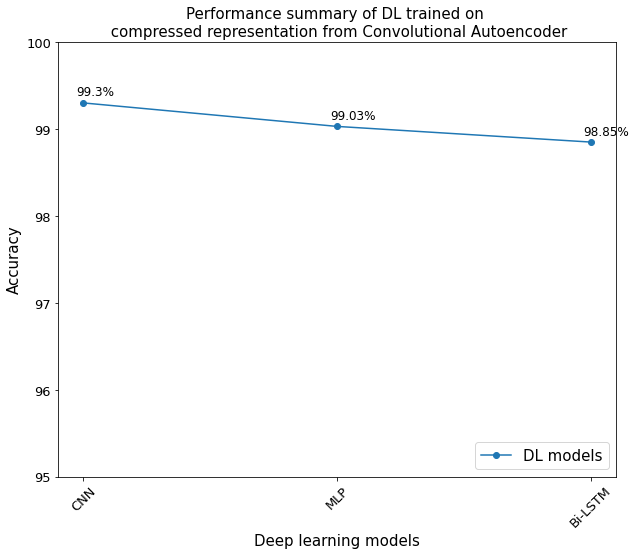

In [8]:
import matplotlib.pyplot as plt


DL_result  = [99.30, 99.03, 98.85]



methods = ['CNN', 'MLP', 'Bi-LSTM']
# Initialise the figure and axes.
fig, ax = plt.subplots(1, figsize=(10, 8))
# Set the title for the figure
plt.title('Performance summary of DL trained on \n compressed representation from Convolutional Autoencoder', fontsize=15, )

plt.plot(methods, DL_result, 'o-', label="DL models")
# plt.plot(methods, result_21genes, 'o-', label="21 hallmark genes")     

plt.legend(loc="lower right", fontsize = 15)

plt.xticks(rotation = 45)
plt.xlabel('Deep learning models', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)



for i, v in enumerate(DL_result):
    ax.annotate(str(v)+"%", xy=(i,v), xytext=(-7,7), textcoords='offset points', fontsize = 12)

ax.set_ylim([95, 100])

plt.savefig("High resoltion_DL.png",dpi=1000)
